Loss = 0.1%
  Avg throughput: 5.8692 Mbps
  Avg throughput: 502.50 MSS/s

Loss = 1.0%
  Avg throughput: 1.6591 Mbps
  Avg throughput: 142.05 MSS/s

Loss = 2.0%
  Avg throughput: 0.8048 Mbps
  Avg throughput: 68.90 MSS/s



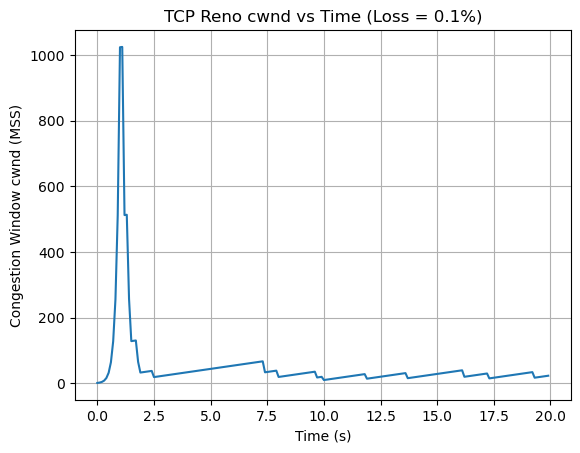

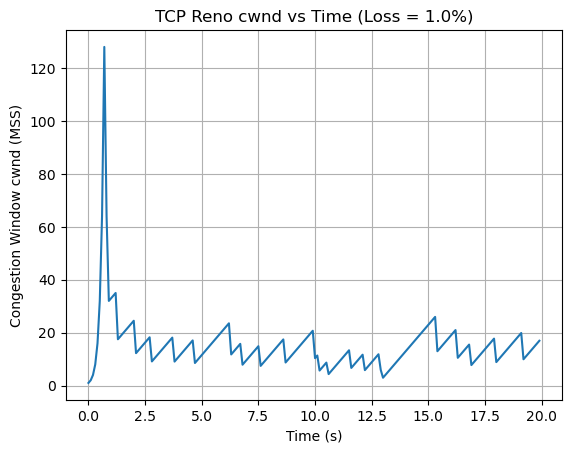

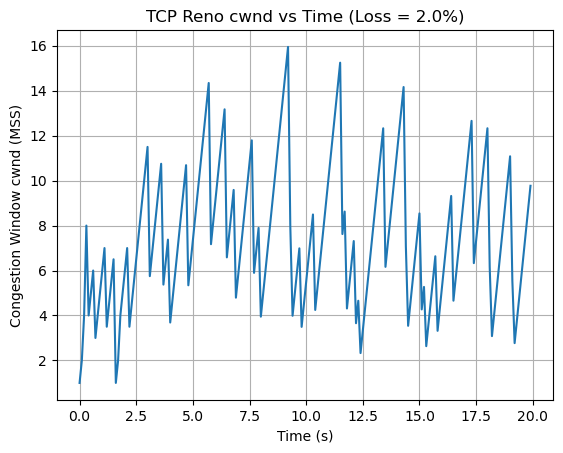

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
DURATION = 20.0      # seconds
RTT = 0.1            # seconds
MSS_BYTES = 1460     # bytes
MAX_CWND = 2000      # in MSS, just to keep things bounded
np.random.seed(42)   # for reproducibility

def simulate_tcp_reno(loss_prob, duration=DURATION, rtt=RTT, mss_bytes=MSS_BYTES):
    t = 0.0
    cwnd = 1.0              # in MSS
    ssthresh = 1000.0       # in MSS
    times = []
    cwnds = []
    bytes_acked = 0

    while t < duration:
        times.append(t)
        cwnds.append(cwnd)

        pkts = max(int(cwnd), 1)
        # simulate packet loss for this window
        losses = np.random.rand(pkts) < loss_prob
        num_lost = losses.sum()
        num_ok = pkts - num_lost

        # delivered packets contribute to throughput
        bytes_acked += num_ok * mss_bytes

        if num_lost > 0:
            # If many packets lost, treat as timeout, else fast retransmit
            loss_fraction = num_lost / pkts
            if loss_fraction > 0.3:
                # Timeout: cwnd reset to 1 MSS, ssthresh halved
                ssthresh = max(cwnd / 2.0, 1.0)
                cwnd = 1.0
            else:
                # Triple-duplicate ACK style fast recovery: multiplicative decrease
                ssthresh = max(cwnd / 2.0, 1.0)
                cwnd = ssthresh
        else:
            # No loss: normal Reno growth
            if cwnd < ssthresh:
                # slow start: roughly exponential growth
                cwnd = min(cwnd * 2.0, MAX_CWND)
            else:
                # congestion avoidance: linear increase
                cwnd = min(cwnd + 1.0, MAX_CWND)

        t += rtt

    avg_throughput_bps = bytes_acked * 8.0 / duration
    avg_throughput_mbps = avg_throughput_bps / 1e6
    avg_throughput_mss_per_sec = (bytes_acked / mss_bytes) / duration

    return {
        "times": np.array(times),
        "cwnds": np.array(cwnds),
        "avg_throughput_mbps": avg_throughput_mbps,
        "avg_throughput_mss_per_sec": avg_throughput_mss_per_sec
    }

loss_scenarios = [0.001, 0.01, 0.02]  # 0.1%, 1%, 2%
results = {}

for p in loss_scenarios:
    results[p] = simulate_tcp_reno(p)

# Print average throughput values
for p, res in results.items():
    print(f"Loss = {p*100:.1f}%")
    print(f"  Avg throughput: {res['avg_throughput_mbps']:.4f} Mbps")
    print(f"  Avg throughput: {res['avg_throughput_mss_per_sec']:.2f} MSS/s")
    print()

# Plot cwnd vs time for each loss case (separate plots)
for p in loss_scenarios:
    res = results[p]
    plt.figure()
    plt.plot(res["times"], res["cwnds"])
    plt.xlabel("Time (s)")
    plt.ylabel("Congestion Window cwnd (MSS)")
    plt.title(f"TCP Reno cwnd vs Time (Loss = {p*100:.1f}%)")
    plt.grid(True)
    plt.show()
